In [3]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, BatchNormalization, Activation, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
#suppressing the warnings
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/SuicideAndDepression_Detection.csv')
dataset.rename(columns={'text':'Text', 'class':'Class'}, inplace=True)
dataset.sample(5)

,Text,Class
269251,I'm so disappointed in myselfI never really im...,depression
239223,I feel like I'm clinging to life sometimesI fe...,depression
89984,My Depression and Anxiety has ruined Christmas...,depression
254101,Do Racist Subreddits Exist? I noticed that a l...,teenagers
39726,I almost took a bottle of pills. Too long of a...,SuicideWatch


In [5]:
dataset.loc[dataset['Class'] == 'teenagers','Class'] = 'Other'
dataset.loc[dataset['Class'] == 'depression','Class'] = 'Depression'
dataset.sample(5)

,Text,Class
239981,"A question on lifelong depression?Hi all, an h...",Depression
233782,NightimeDoes your depression fluctuate during ...,Depression
131706,29M looking for Best way to end it with girlfr...,SuicideWatch
112844,I don't want to wake up anymore.I wasn't going...,Depression
139421,Wanting to die: trying to be happy and don't s...,SuicideWatch


In [6]:
print(f'Size Of Dataset: {dataset.shape}')

Size Of Dataset: (348124, 2)


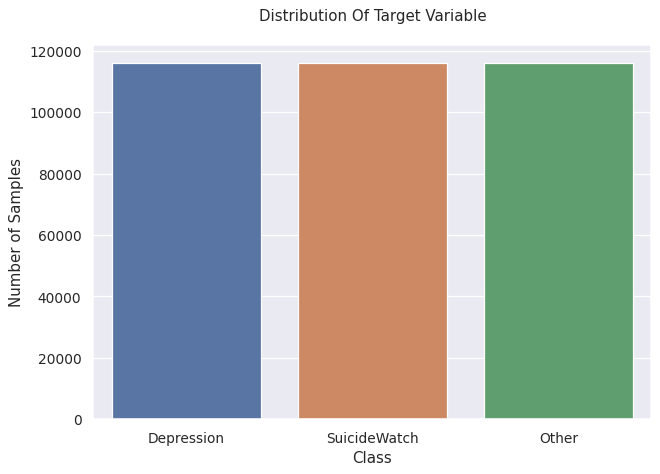

In [7]:
plt.rcParams['figure.figsize'] = [8,5.5]
plt.rcParams['figure.dpi'] = 90
sns.set(style='darkgrid')

sns.countplot('Class', data=dataset)
plt.ylabel("Number of Samples")
plt.title('Distribution Of Target Variable', pad=20)
plt.show()

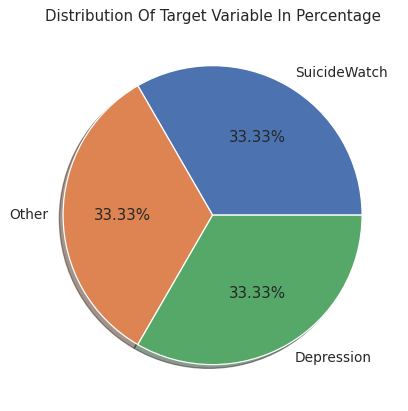

In [8]:
dataset['Class'].value_counts().plot.pie(autopct='%1.2f%%', shadow=True)
plt.title('Distribution Of Target Variable In Percentage')
plt.ylabel("")
plt.show()

In [9]:
def char_counts(x):
  #spliting the words
  s = x.split()
  #joining without space
  x = ''.join(x)
  return len(x)

In [10]:
#adding more information for exploratory data analysis
dataset['Word_Counts'] = dataset['Text'].apply(lambda x: len(str(x).split()))
dataset['Char_Counts'] = dataset['Text'].apply(lambda x: char_counts(str(x)))
dataset['Stop_Words_Count'] = dataset['Text'].apply(lambda x: len([word for word in str(x).split() if word in stopwords]))
dataset['Unique_Word_Count'] = dataset['Text'].apply(lambda x: len(set(str(x).split())))
dataset['Punctuation_Count'] = dataset['Text'].apply(lambda x: len([word for word in str(x) if word in string.punctuation]))

In [11]:
dataset.head(3)

,Text,Class,Word_Counts,Char_Counts,Stop_Words_Count,Unique_Word_Count,Punctuation_Count
0,Does life actually work for most / non-depress...,Depression,44,254,20,40,11
1,I found my friend's bodyIt was almost nine yea...,Depression,592,3009,280,310,97
2,Ex Wife Threatening SuicideRecently I left my ...,SuicideWatch,143,715,75,99,12


In [12]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 95

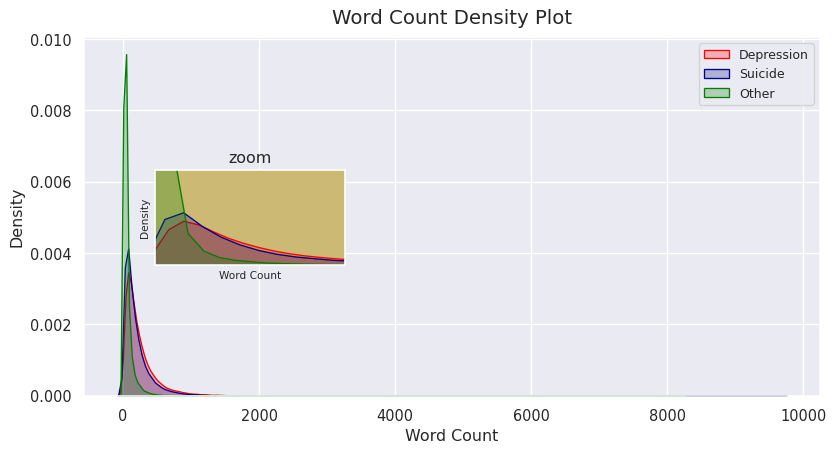

In [13]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Word_Counts'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Word_Counts'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Word_Counts'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Word Count')    
plt.title('Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Word_Counts'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Word_Counts'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Word_Counts'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

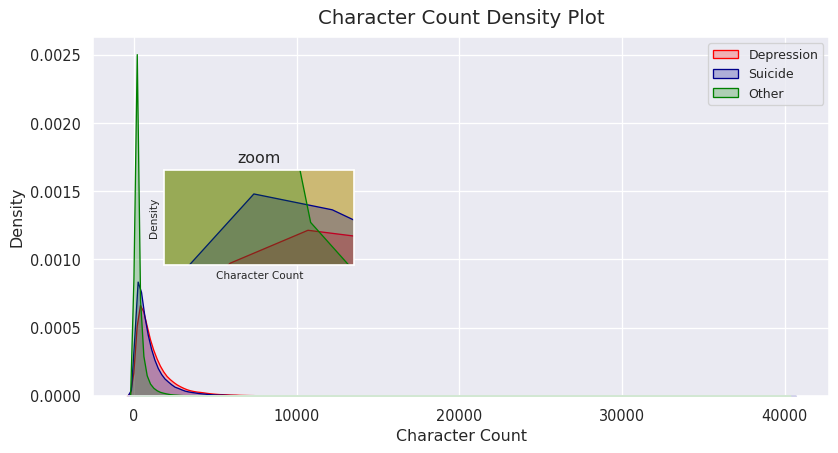

In [14]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Char_Counts'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Char_Counts'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Char_Counts'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Character Count')    
plt.title('Character Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Char_Counts'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Char_Counts'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Char_Counts'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Character Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0.0005,0.00095])
plt.show()

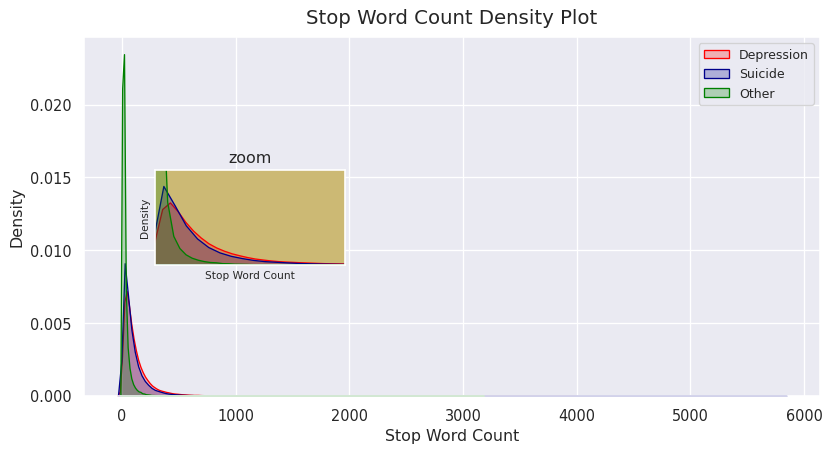

In [15]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Stop_Words_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Stop_Words_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Stop_Words_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Stop Word Count')    
plt.title('Stop Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Stop_Words_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Stop_Words_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Stop_Words_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Stop Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.011])
plt.show()

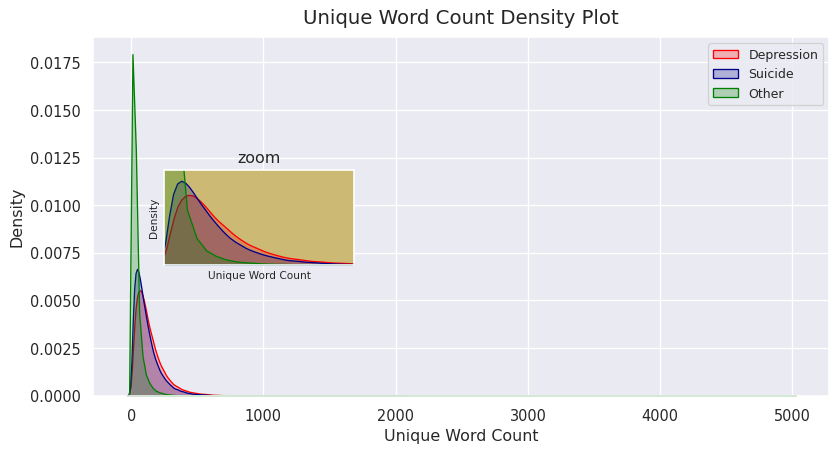

In [16]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Unique_Word_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Unique_Word_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Unique_Word_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Unique Word Count')    
plt.title('Unique Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Unique_Word_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Unique_Word_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Unique_Word_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Unique Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

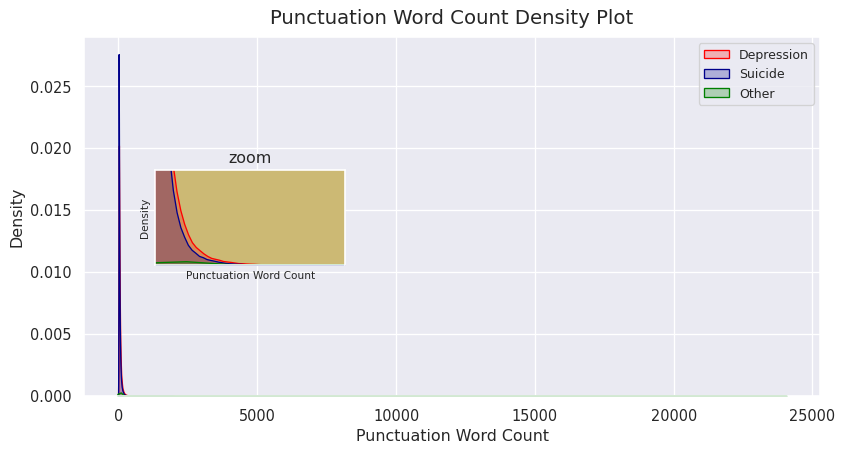

In [17]:
fig, ax = plt.subplots()
sns.kdeplot(dataset[dataset['Class']=='Depression']['Punctuation_Count'], label='Depression', color='red', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Punctuation_Count'], label='Suicide', color='darkblue', shade=True, x=1000)
sns.kdeplot(dataset[dataset['Class']=='Other']['Punctuation_Count'], label='Other', color='green', shade=True, x=1000)
ax.set_xlabel('Punctuation Word Count')    
plt.title('Punctuation Word Count Density Plot', pad=10,  fontsize=15)
plt.legend(loc = 'upper right', prop={'size': 9.5})

ax2 = plt.axes([0.2, 0.4, .2, .2], facecolor='y')
sns.kdeplot(dataset[dataset['Class']=='Depression']['Punctuation_Count'],  color='red', shade=True)
sns.kdeplot(dataset[dataset['Class']=='SuicideWatch']['Punctuation_Count'], color='darkblue', shade=True)
sns.kdeplot(dataset[dataset['Class']=='Other']['Punctuation_Count'], color='green', shade=True)
ax2.axes.get_xaxis().set_ticks([])
ax2.axes.get_yaxis().set_ticks([])
plt.xlabel('Punctuation Word Count', fontsize=8)
plt.ylabel('Density', fontsize=8)
ax2.set_title('zoom')
ax2.set_xlim([0,500])
ax2.set_ylim([0,0.0075])
plt.show()

In [18]:
!pip -q install contractions
import contractions
import unicodedata

     |████████████████████████████████| 106 kB 4.4 MB/s 
     |████████████████████████████████| 287 kB 27.9 MB/s 


In [19]:
def remove_accented(x):
  x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return x

In [20]:
freq_comm = pd.Series(dataset['Text']).value_counts()
f20 = freq_comm[:50]
rare20 = freq_comm.tail(50)

In [21]:
def get_clean(X):
  X = str(X).lower()
  X = X.replace('\\', ' ').replace('_', ' ').replace('.', ' ').replace(':', '')
  X = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?',"",  X)
  X = re.sub(r'\brt\b', '', X).strip()
  X = re.sub('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});',"", X)
  X = re.sub(r'[^\w\d\s]+','', X)
  X = ' '.join(X.split())
  X = BeautifulSoup(X, 'lxml').get_text().strip()
  X = remove_accented(X)
  X = re.sub(r'[^\w ]+','',X)
  X = re.sub("(.)\\1{2,}", "\\1", X)
  X = contractions.fix(X)
  #X = ' '.join([word for word  in X.split() if word not in stopwords])
  X = ' '.join([word for word in X.split() if word not in f20]) 
  X = ' '.join([word for word in X.split() if word not in rare20])
  return X

In [22]:
dataset['Text'] = dataset['Text'].apply(lambda X : get_clean(X))
dataset = dataset[dataset['Text'].str.split().str.len().ge(3)]

In [23]:
dataset.sample(4)

,Text,Class,Word_Counts,Char_Counts,Stop_Words_Count,Unique_Word_Count,Punctuation_Count
206935,my doctor just highly recommended i get electr...,Depression,208,1177,93,145,31
108387,stupid thing to get depressed about 3898 why d...,Depression,169,955,80,119,24
331984,i need helpi find myself thinking nearly every...,SuicideWatch,139,723,62,93,28
153611,nobody caresi cannot do this anymore when i wa...,SuicideWatch,133,670,61,93,27


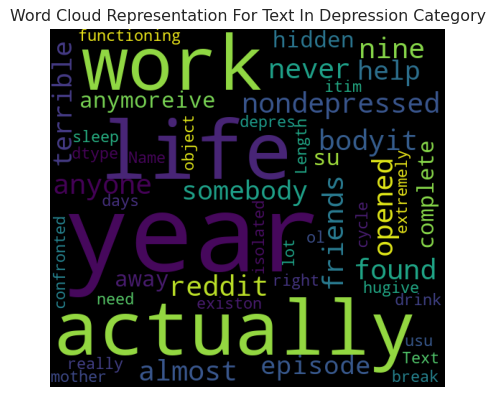

In [24]:
toxic = str(dataset[dataset['Class']=='Depression'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In Depression Category')
plt.axis('off')
plt.show()

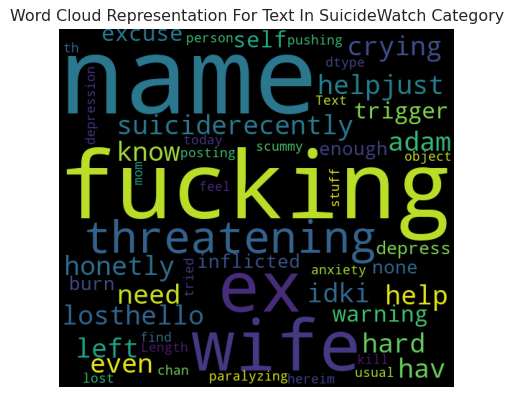

In [25]:
toxic = str(dataset[dataset['Class']=='SuicideWatch'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In SuicideWatch Category')
plt.axis('off')
plt.show()

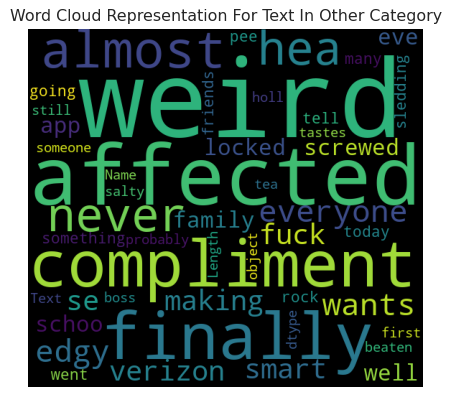

In [26]:
toxic = str(dataset[dataset['Class']=='Other'].Text)
word_cloud = WordCloud(width=550, height=500, max_font_size=150).generate(toxic)
plt.imshow(word_cloud)
plt.title('Word Cloud Representation For Text In Other Category')
plt.axis('off')
plt.show()

In [27]:
X = dataset['Text']

In [28]:
Y_df = dataset['Class']
Y_df = pd.DataFrame({'Class':Y_df.values})
Y_df['Class'] = Y_df.Class.astype('category')
Y_df['Label_Code'] = Y_df["Class"].cat.codes
display(Y_df.sample(5))

,Class,Label_Code
280457,Depression,0
271139,Depression,0
34285,Depression,0
43755,SuicideWatch,2
149603,Depression,0


In [29]:
Y = to_categorical(Y_df['Label_Code'])
Y = pd.DataFrame({'Depression': Y[:, 0], 'SuicideWatch': Y[:, 1], 'Other': Y[:, 2]})
display(Y.sample(4))

,Depression,SuicideWatch,Other
100409,1.0,0.0,0.0
310519,0.0,0.0,1.0
50037,0.0,0.0,1.0
143772,0.0,1.0,0.0


In [30]:
token = Tokenizer()
token.fit_on_texts(X)

In [31]:
vocab_size = len(token.word_index) + 1
print('The size of vocab:', vocab_size)

The size of vocab: 288251


In [32]:
encoded_text = token.texts_to_sequences(X)
max_length = len(X.max()) + 5  
X = pad_sequences(encoded_text, maxlen=max_length, padding='pre')

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0, stratify=Y)

In [34]:
print(f'Shape of train Dataset: {X_train.shape, y_train.shape}')
print(f'Shape of test Dataset: {X_test.shape, y_test.shape}')

Shape of train Dataset: ((208708, 458), (208708, 3))
Shape of test Dataset: ((139140, 458), (139140, 3))


In [35]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(70, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Conv1D(140, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(3, activation='softmax'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 458, 100)          28825100  
                                                                 
 conv1d (Conv1D)             (None, 457, 70)           14070     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 228, 70)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 228, 70)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 227, 140)          19740     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 113, 140)         0         
 1D)                                                    

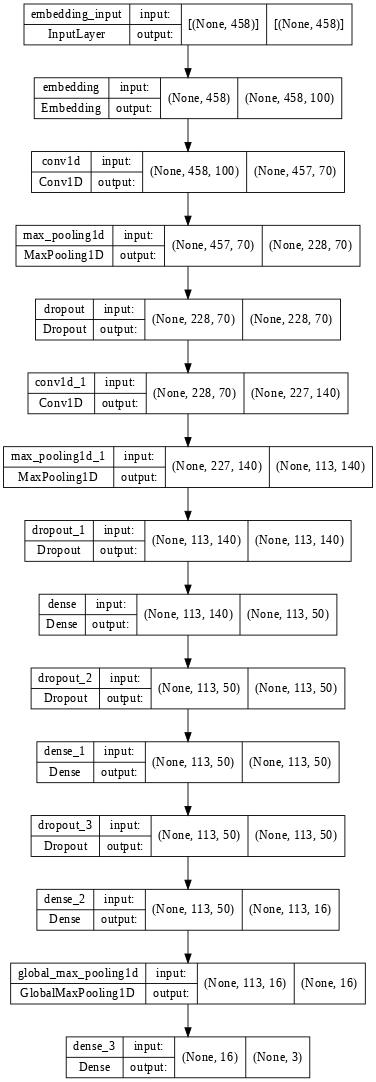

In [37]:
plot_model(model, show_shapes=True, show_layer_names=True, dpi=64)

In [38]:
model.compile(optimizer= SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
r = model.fit(X_train, y_train, epochs=150, batch_size=150, validation_data=(X_test, y_test))

Epoch 1/150
1392/1392 [==============================] - 76s 46ms/step - loss: 1.0387 - accuracy: 0.4888 - val_loss: 1.0614 - val_accuracy: 0.3822
Epoch 2/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.9319 - accuracy: 0.5221 - val_loss: 1.0154 - val_accuracy: 0.5072
Epoch 3/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.9056 - accuracy: 0.5336 - val_loss: 0.9540 - val_accuracy: 0.5321
Epoch 4/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.8669 - accuracy: 0.5522 - val_loss: 0.8732 - val_accuracy: 0.5512
Epoch 5/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.8193 - accuracy: 0.5742 - val_loss: 0.8319 - val_accuracy: 0.5684
Epoch 6/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.7865 - accuracy: 0.6060 - val_loss: 0.8002 - val_accuracy: 0.5773
Epoch 7/150
1392/1392 [==============================] - 64s 46ms/step - loss: 0.7688 - accuracy: 0.6231 - val_loss: 0

In [39]:
import math   
print(f'The traning accuracy of model is {math.floor(r.history["accuracy"][-1] * 100)} %')
print(f'The validation accuracy of model is {math.floor(r.history["val_accuracy"][-1] * 100)} %')

The traning accuracy of model is 86 %
The validation accuracy of model is 72 %


In [40]:
print(f'The traning loss of model is {r.history["loss"][-1]:.4}')
print(f'The validation loss of model is {r.history["val_loss"][-1]:.4}')

The traning loss of model is 0.3362
The validation loss of model is 0.6376


In [41]:
plt.rcParams['figure.dpi'] = 75
plt.rcParams['figure.figsize'] = [20,7]

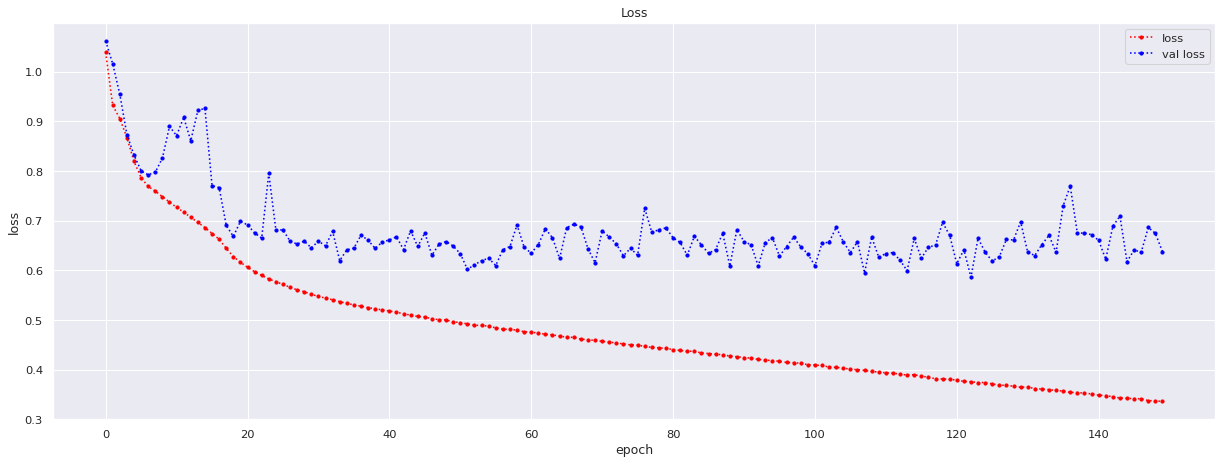

In [42]:
plt.title('Loss')
plt.plot(r.history['loss'], ".:", label='loss', linewidth=1.5, color="red")
plt.plot(r.history['val_loss'], ".:", label='val loss', linewidth=1.5, color="blue")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

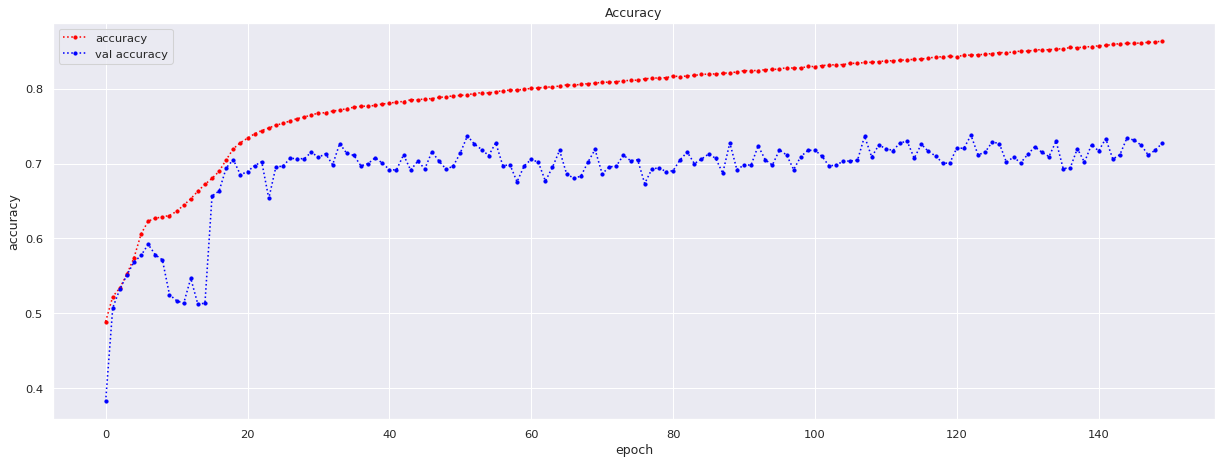

In [43]:
plt.title('Accuracy')
plt.plot(r.history['accuracy'], ".:", label='accuracy', linewidth=1.5, color="red")
plt.plot(r.history['val_accuracy'], ".:", label='val accuracy', linewidth=1.5, color="blue")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [44]:
classes = ['Depression', 'Other', 'SuicideWatch']

In [45]:
text = "I'm felling hopless and sad I have lost my way and don't know what do."

In [46]:
text = get_clean(text)
en_text = encoded_text = token.texts_to_sequences(text)
en_text = pad_sequences(en_text, maxlen=max_length, padding='pre')

In [ ]:
x = get_clean(text)
x = encoded_text = token.texts_to_sequences(x)
x = pad_sequences(x, maxlen=max_length, padding='pre')
y_pred = np.argmax(my_model.h5.model.predict(x))

In [ ]:
print(f'Sentence: {text}')
print(f'Result: Model has found symptoms of {classes[y_pred]} in the above sentence.')